In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/Users/willbarnes/Documents/Rice/Research/EBTEL-2fluid_repo/bin/')
import ebtel2fl_plot as ebp
reload(ebp)

<module 'ebtel2fl_plot' from '/Users/willbarnes/Documents/Rice/Research/EBTEL-2fluid_repo/bin/ebtel2fl_plot.pyc'>

#EBTEL Energy Budget Analysis

In the power-law distributed events that we've been looking at, it seems that our plasma isn't getting hot enough: $T_{\mathrm{max}}$, the temperature at which the emission measure ($\mathrm{EM}$) peaks, is significantly lower than that seen in both simulation and observation, $\log(T_{\mathrm{max}})\sim6.6$.

However, in our runs that use uniform event amplitudes show much better agreement with $T_{\mathrm{max}}$ though for especially long loop-lengths, $T_{\mathrm{max}}$ is too high, . Thus, there seems to be a problem with the energy budget of our power-law distributed nanoflare event amplitudes, $\log(T_{\mathrm{max}})\sim7.0$.

First, let's define a function for choosing from a power-law distribution. 

In [6]:
def pl_dist(a0,a1,alpha,x):
        return ((a1**(alpha+1) - a0**(alpha+1))*x + a0**(alpha+1))**(1/(alpha+1))

Now, let's map our bounds on the energy per nanoflare to the volumetric energy rate.

In [7]:
def en2vol_en_rate(Q,loop_length,area,t_pulse):
    return Q/(loop_length*area*t_pulse)

Let's choose some parameters for the loop half-length ($L$), the cross-sectional area ($A$), and the duration of the heating events ($\tau$).

In [8]:
L=40.0e+8
A = 1.0e+14
tau=100.0
total_time = 8.0e+4

Finally, let's set our bounds on the distribution in terms of the total energy released per event.

In [9]:
q0 = 1.0e+24
q1 = 1.0e+25

Now, we can build a list of indices for our distribution and sample from each of these distributions with our given bounds. First, set the number of samples we will take.

In [10]:
alphas = [-1.5,-2.0,-2.5]
t_wait = np.arange(250,5250,250)
distributions = []
for a in alphas:
    distributions_temp = []
    for tw in t_wait:
        np.random.seed()
        distributions_temp.append(pl_dist(en2vol_en_rate(q0,L,A,tau),en2vol_en_rate(q1,L,A,tau),a,np.random.rand(int(np.ceil(total_time/(tau + tw))))))
    distributions.append(distributions_temp)

Now, what is the mean volumetric heating rate amplitude for each value of $\alpha$?

In [11]:
#function to calculate Hn for triangular heating profiles
def calc_hn(amp_list,tpulse,total_time):
    return 0.5*np.sum(amp_list)*tpulse/total_time

In [12]:
hn_list =[]
for i in range(len(alphas)):
    hn_list_temp = []
    for j in range(len(t_wait)):
        hn_list_temp.append(calc_hn(distributions[i][j],tau,total_time))
    hn_list.append(hn_list_temp)

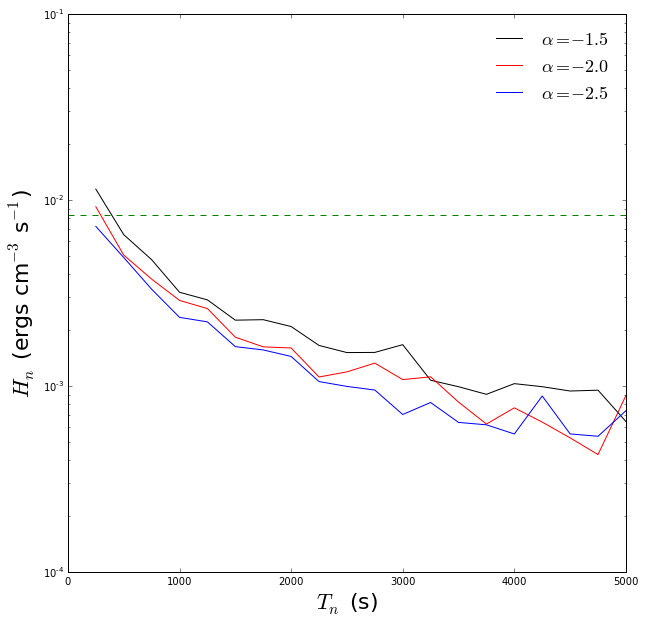

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(t_wait,hn_list[0],'k',label=r'$\alpha=-1.5$')
ax.plot(t_wait,hn_list[1],'r',label=r'$\alpha=-2.0$')
ax.plot(t_wait,hn_list[2],'b',label=r'$\alpha=-2.5$')
ax.axhline(y=8.3e-3,color='g',linestyle='--')
ax.set_xlabel(r'$T_n$ (s)',fontsize=22)
ax.set_ylabel(r'$H_n$ (ergs cm$^{-3}$ s$^{-1}$)',fontsize=22)
ax.set_yscale('log')
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()

Thus, we can see that the time-averaged volumetric heating rate $H_n$ varies significantly with $T_n$ and also shows some variation with $\alpha$. We need to find a way to ensure approximately equal $H_n$ across $T_n$ and $\alpha$.

Build the histograms for these three distributions.

No file specified. Variable namespace will not be populated.


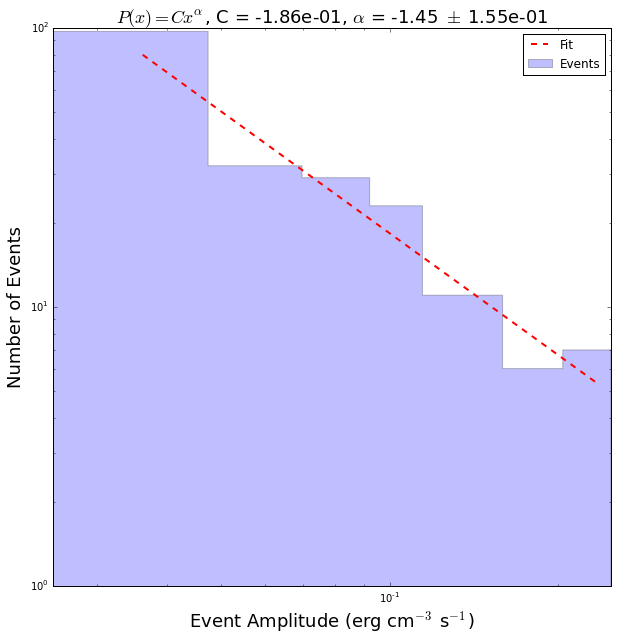

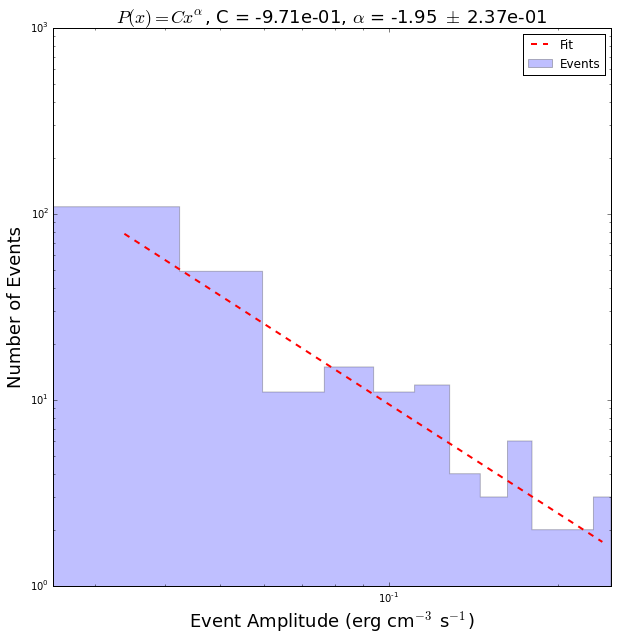

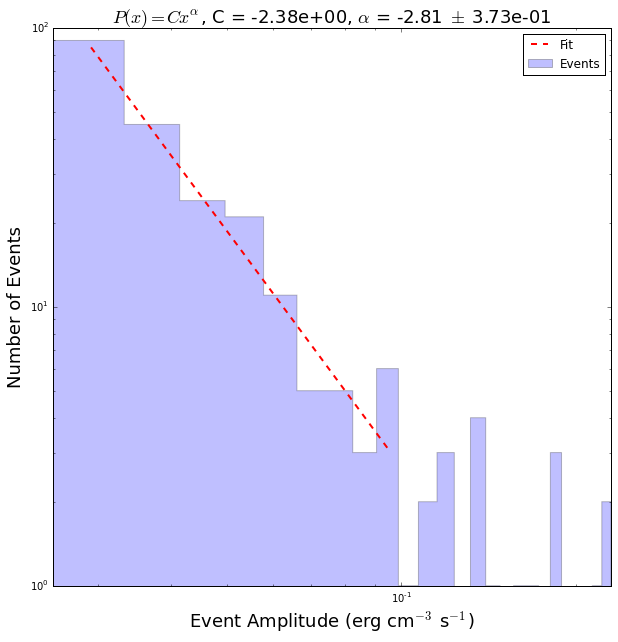

In [14]:
pl_plotter =ebp.Plotter()
for i in range(len(alphas)):
    pl_plotter.events = distributions[i][0] #use case with most events
    pl_plotter.plot_event_distribution()

We would like to keep $H_n$ constant so that, roughly, we are inputting the same amount of energy into our loop sub-element, even when using a power law distribution. By allowing $\tau$ to be a free parameter, we can see that $H_n$ is not constant and decreases by $\sim2$ with decreasing $\alpha$.

Recall that $N=T_{\mathrm{total}}/(\tau+T_N)$ and $H_nT_{\mathrm{total}}=\sum^N_{i=1}Q_i$ where $Q_i=1/2\tau_iH_i=\tau/2H_i$. Letting $\phi=H_nT_{\mathrm{total}}=\mathrm{const.}$, we can combine all of these expressions as a single equation with one unknown $\tau$, $$\phi=\frac{\tau}{2}\sum_{i=1}^{N(\tau)}H_i(\tau),$$where we note that $H_i$, the $i^{\mathrm{th}}$ event amplitude, is also a function of the pulse width $\tau$.

To determine the correct value of $\tau$, we will need to iterate over a range of $\tau$ values in order to find the one that best suites our required conditions. First, let's write a function that evaluates the RHS of the equation.

In [15]:
def tau_minimizer(tau,constant_dict):
    #calculate number of events
    num_events = int(np.ceil(constant_dict['total_time']/(tau + constant_dict['t_wait'])))
    #calculate LHS constant
    phi = constant_dict['H_n']*constant_dict['total_time']
    #calculate event amplitudes
    a0 = constant_dict['Q0']/(constant_dict['loop_length']*constant_dict['area']*tau)
    a1 = constant_dict['Q1']/(constant_dict['loop_length']*constant_dict['area']*tau)
    np.random.seed()
    hi_list = pl_dist(a0,a1,constant_dict['alpha'],np.random.rand(num_events))
    sum_hi = np.sum(hi_list)
    #return difference between RHS and LHS
    delta = np.fabs(phi - tau/2.0*sum_hi)
    return delta

Let's populate the constant dictionary with all of the parameters that we will need.

In [16]:
constant_dict = {'total_time':total_time,'loop_length':L,'area':A,'H_n':8.3e-3}
constant_dict['alpha'] = -1.5
constant_dict['Q0'] = q0
constant_dict['Q1'] = q1

Now, we can choose a range of $\tau$ test values and run the minimizer over this range to find the optimal $\tau$ value. First, let's plot the tau minimizer function versus our range of $\tau$.

In [17]:
tau = np.logspace(0,3.5,500)
t_wait = np.arange(250,1250,250)
delta_master = []
for tw in t_wait:
    constant_dict['t_wait'] = tw
    delta = []
    for t in tau:
        delta.append(tau_minimizer(t,constant_dict))
    delta_master.append(delta)

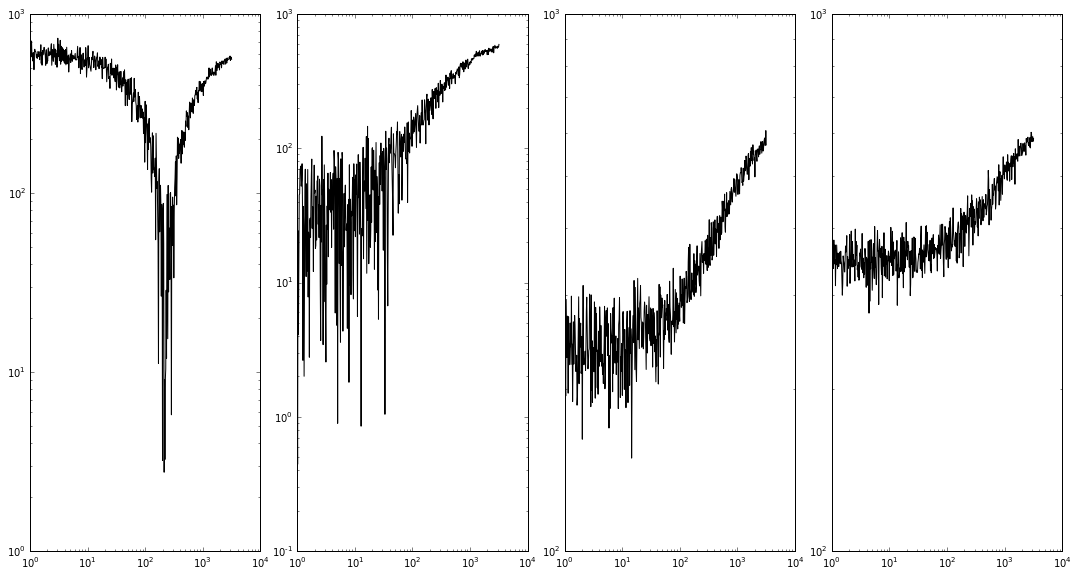

In [18]:
fig,ax = plt.subplots(1,len(t_wait),figsize=(15,8))
fig.tight_layout()
for i in range(len(t_wait)):
    ax[i].plot(tau,delta_master[i],'k')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
plt.show()

This is yielding confusing results; to simplify the problem a bit, let's just think about the problem in terms of $N$, the total number of events needed to ensure that $H_nT_{\mathrm{total}}=\sum_iQ_i$, where we will instead construct our distribution from the energy density $Q_i$ and not the heating rate $H_i$. 

In [19]:
def tau_minimizer_2(n,constant_dict):
    #calculate phi
    phi = constant_dict['total_time']*constant_dict['H_n']
    #calculate amplitudes from power-law distribution
    a0 = constant_dict['Q0']/(constant_dict['area']*constant_dict['loop_length'])
    a1 = constant_dict['Q1']/(constant_dict['area']*constant_dict['loop_length'])
    np.random.seed()
    qi = pl_dist(a0,a1,constant_dict['alpha'],np.random.rand(n))
    return np.fabs(phi - np.sum(qi))/np.fabs(phi + np.sum(qi))

In [20]:
num_events = np.logspace(2,4,1000)
delta = []
for a in alphas:
    delta_temp = []
    constant_dict['alpha'] = a
    for n in num_events:
        delta_temp.append(tau_minimizer_2(n,constant_dict))
    delta.append(delta_temp)

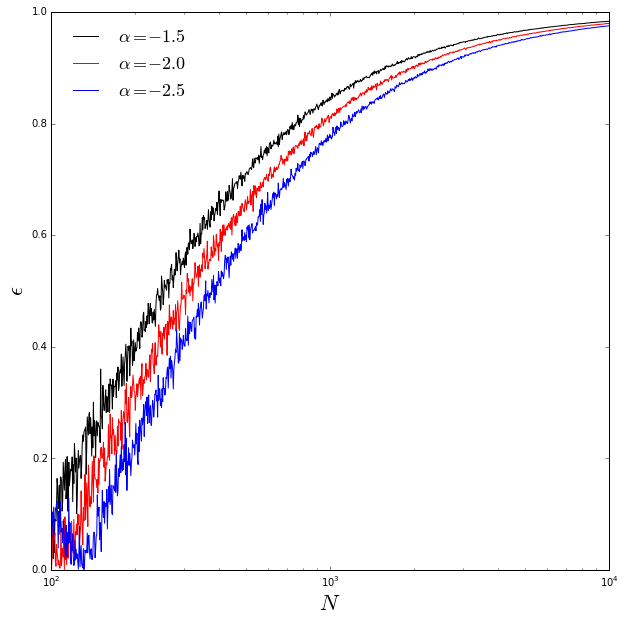

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(num_events,delta[0],'k',label=r'$\alpha=-1.5$')
ax.plot(num_events,delta[1],'r',label=r'$\alpha=-2.0$')
ax.plot(num_events,delta[2],'b',label=r'$\alpha=-2.5$')
ax.set_xscale('log')
ax.set_xlabel(r'$N$',fontsize=22)
ax.set_ylabel(r'$\epsilon$',fontsize=22)
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()

From the above plot, we can estimate the optimal value of $N$ and then from this value, calculate $\tau$ for a range of $T_n$ for our different values of $\alpha$ using the formula $N=T_{\mathrm{total}}/(\tau + T_n)~\rightarrow~\tau=T_{\mathrm{total}}/N-T_n$

In [22]:
n_optimal = []
for d in delta:
    n_optimal.append(int(np.ceil(np.mean(np.array(num_events)[np.where(d<1.05*np.min(d))]))))

In [23]:
n_optimal

[102, 112, 132]

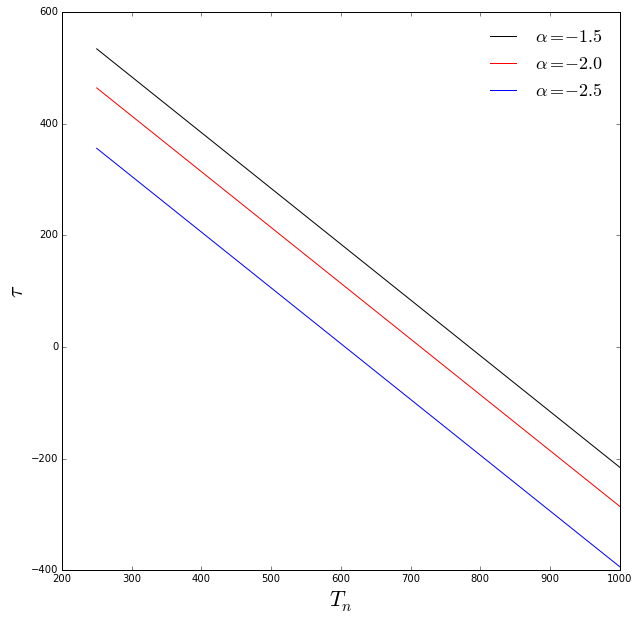

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(t_wait,constant_dict['total_time']/n_optimal[0]-t_wait,'k',label=r'$\alpha=-1.5$')
ax.plot(t_wait,constant_dict['total_time']/n_optimal[1]-t_wait,'r',label=r'$\alpha=-2.0$')
ax.plot(t_wait,constant_dict['total_time']/n_optimal[2]-t_wait,'b',label=r'$\alpha=-2.5$')
#ax.set_yscale('log')
ax.set_xlabel(r'$T_n$',fontsize=22)
ax.set_ylabel(r'$\tau$',fontsize=22)
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()

This cannot be right as we get resulting values of $\tau<0$. Let's adjust our range for our power-law distribution and then adjust our minimizer function to choose from a distribution of energy densities $\mathcal{Q}_i$ rather than heating rates $H_i$ such that the equation we will be solving now is given by $$\phi=\sum_{i=1}^{T_{total}/(\tau+T_n)}\mathcal{Q}_i.$$

In [25]:
constant_dict['Q0'] = 1.0e+23
constant_dict['Q1'] = 1.0e+24

In [26]:
def tau_minimizer_3(tau,constant_dict):
    #calculate number of events
    num_events = int(np.ceil(constant_dict['total_time']/(tau + constant_dict['t_wait'])))
    #calculate LHS constant
    phi = constant_dict['H_n']*constant_dict['total_time']
    #calculate event amplitudes
    q0 = constant_dict['Q0']/(constant_dict['loop_length']*constant_dict['area'])
    q1 = constant_dict['Q1']/(constant_dict['loop_length']*constant_dict['area'])
    np.random.seed()
    hi_list = pl_dist(q0,q1,constant_dict['alpha'],np.random.rand(num_events))
    sum_hi = np.sum(hi_list)
    #return difference between RHS and LHS
    delta = np.fabs(phi - sum_hi)/np.fabs(phi + sum_hi)
    return delta

In [27]:
tau = np.logspace(0,3,1000)
delta = []
constant_dict['t_wait'] = 250
constant_dict['alpha'] = -2.5
for t in tau:
    delta.append(tau_minimizer_3(t,constant_dict))

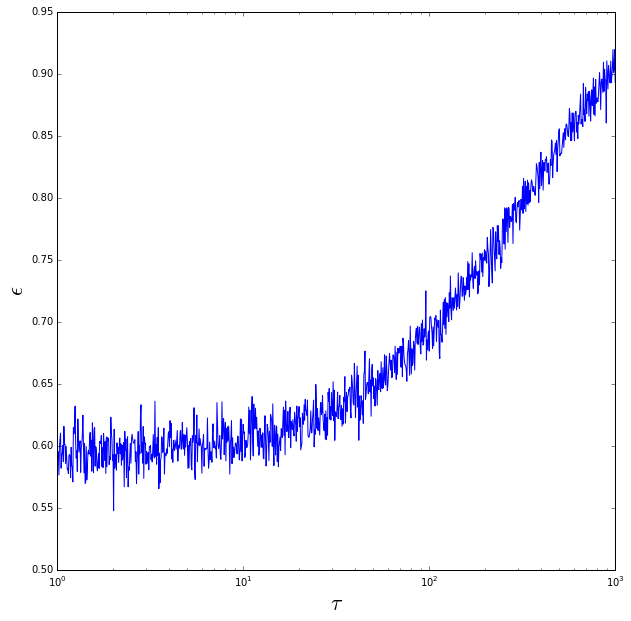

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(tau,delta)
ax.set_xscale('log')
ax.set_xlabel(r'$\tau$',fontsize=22)
ax.set_ylabel(r'$\epsilon$',fontsize=22)
plt.show()

In [29]:
constant_dict['H_n']*constant_dict['total_time']

664.0

##Predicted Heating Rates

We want to know how much heat we need to dump into our loop to reach a predicted temperature. We know from observations that the temperature of peak emission is $\sim 4$ MK or $\log(T_{\mathrm{peak}})\sim6.6$. Using the hydrodynamic equations at the onset of heating, when only the ad-hoc heating and thermal conduction are important, $$H=\frac{\partial F_C}{\partial s},$$and integrating over a coronal loop length$$H\approx\frac{\kappa_0T_{\mathrm{peak}}^{7/2}}{L^2}.$$Thus, we can plug in $T_{\mathrm{peak}}$ and our set of loop lengths and determine the needed time-averaged heating rate.

In [30]:
def heating_rate_approx(tpeak,L):
    kappa = 1.0e-6
    return kappa*tpeak**(3.5)/L**2

In Warren et al.(2011), $~\bar{H}=8.3\times10^{-3}$ ergs cm$^{-3}$ s$^{-1}$ and $L=75$ Mm to acheive a peak temperature of 4 MK.

In [31]:
heating_rate_approx(4.0e+6,75.0e+8/2.0)

0.009102222222222222

This doesn't seem to match what is reported in Cargill (2014) or Warren et al. (2011). Let's try and use the scaling laws instead to predict the needed average heating rate. Let's look at the needed heating rate for a peak temperature of 4 MK across a range of $L$.

In [32]:
L = np.linspace(20.0e+8,120.0e+8,1000)

In [33]:
def heating_rate_approx_scaling_laws(tpeak,L):
    c1 = 1.83e+3
    c2 = 5.09e+4
    return (c2/(L**2))*(tpeak/c1)**(3.5)

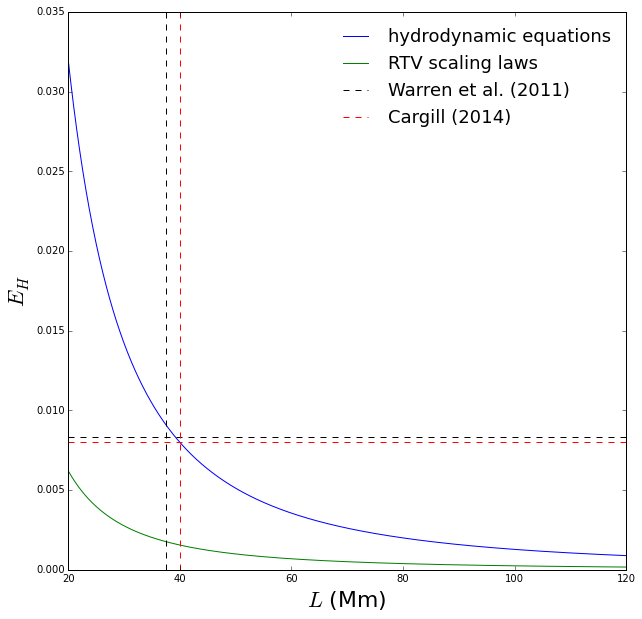

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(L*1.0e-8,heating_rate_approx(4.0e+6,L),label=r'hydrodynamic equations')
ax.plot(L*1.0e-8,heating_rate_approx_scaling_laws(4.0e+6,L),label=r'RTV scaling laws')
ax.axvline(x=75.0/2.0,color='black',linestyle='--',label=r'Warren et al. (2011)')
ax.axhline(y=8.31e-3,color='black',linestyle='--')
ax.axvline(x=40.0,color='red',linestyle='--',label=r'Cargill (2014)')
ax.axhline(y=8.0e-3,color='red',linestyle='--')
ax.set_xlabel(r'$L$ (Mm)',fontsize=22)
ax.set_ylabel(r'$E_H$',fontsize=22)
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()

Our curves still do not match the reported value of $\bar{H}$ at the right value of $L$. What value of $T_{\mathrm{peak}}$ do we need in order to have $\bar{H}=8.31\times10^{-3}~\mathrm{ergs}~\mathrm{cm}^{-3}~\mathrm{s}^{-1}$ at $2L=75~\mathrm{Mm}$?

In [41]:
def tmax_scaling_laws(eh,L):
    c1 = 1.83e+3
    c2 = 5.09e+4
    return c1*(eh*L**2/c2)**(2.0/7.0)
def tmax_hydro(eh,L):
    kappa = 1.0e-6 #8.12e-7
    return (eh*L**2/kappa)**(2.0/7.0)

In [42]:
print "Scaling laws: The needed peak temperature for L=%.1f Mm and Eh = %f is %f MK, log(T_peak) = %f"%(75.0/2.0,8.31e-3,tmax_scaling_laws(8.31e-3,(75.0e+8)/2.0)/1.0e+6,np.log10(tmax_scaling_laws(8.31e-3,(75.0e+8)/2.0)))
print "Hydro equations: The needed peak temperature for L=%.1f Mm and Eh = %f is %f MK, log(T_peak) = %f"%(75.0/2.0,8.31e-3,tmax_hydro(8.31e-3,(75.0e+8)/2.0)/1.0e+6,np.log10(tmax_hydro(8.31e-3,(75.0e+8)/2.0)))

Scaling laws: The needed peak temperature for L=37.5 Mm and Eh = 0.008310 is 6.225151 MK, log(T_peak) = 6.794150
Hydro equations: The needed peak temperature for L=37.5 Mm and Eh = 0.008310 is 3.897275 MK, log(T_peak) = 6.590761


With $2L=75~\mathrm{Mm}$, we can see that the peak temperature is indeed $\sim4~\mathrm{MK}$. Thus, we should be using our hydrodynamic equation approximation with $\kappa_0=10^{-6}$ to find the needed heating rate rather than using a constant value for $H_n$ though it should be noted that this parameter only needs to be adjusted for $L$.

For the Cargill case, we use $L=40$ Mm and $H_n=8\times10^{-3}$. Is this consistent with our above predictions?

In [43]:
print "Hydro equations: The needed peak temperature for L=%.1f Mm and Eh = %f is %f MK, log(T_peak) = %f"%(40.0,8.0e-3,tmax_hydro(8.0e-3,40.0e+8)/1.0e+6,np.log10(tmax_hydro(8.0e-3,40.0e+8)))

Hydro equations: The needed peak temperature for L=40.0 Mm and Eh = 0.008000 is 4.000000 MK, log(T_peak) = 6.602060


##$\tau$-$N$ Predictions Revisited

Let's use the above scalings to predict the time-averaged heating rate in order to find an appropriate value of $\tau$ or $N$.

In [44]:
def tau_minimizer_4(tau,constant_dict):
    #calculate number of events
    num_events = int(np.ceil(constant_dict['total_time']/(tau + constant_dict['t_wait'])))
    #calculate LHS constant
    phi = heating_rate_approx(constant_dict['temp_peak'],constant_dict['loop_length'])*constant_dict['total_time']
    #calculate event amplitudes
    q0 = constant_dict['Q0']/(constant_dict['loop_length']*constant_dict['area'])
    q1 = constant_dict['Q1']/(constant_dict['loop_length']*constant_dict['area'])
    np.random.seed()
    hi_list = pl_dist(q0,q1,constant_dict['alpha'],np.random.rand(num_events))
    sum_hi = np.sum(hi_list)
    #return difference between RHS and LHS
    delta = np.fabs(phi - sum_hi)/np.fabs(phi + sum_hi)
    return delta

In [45]:
tau = np.logspace(0,3,1000)
delta = []
constant_dict['temp_peak'] = 4.0e+6
constant_dict['t_wait'] = 250
constant_dict['alpha'] = -1.5
constant_dict['loop_length'] = (75.0e+8)/2.0
for t in tau:
    delta.append(tau_minimizer_3(t,constant_dict))

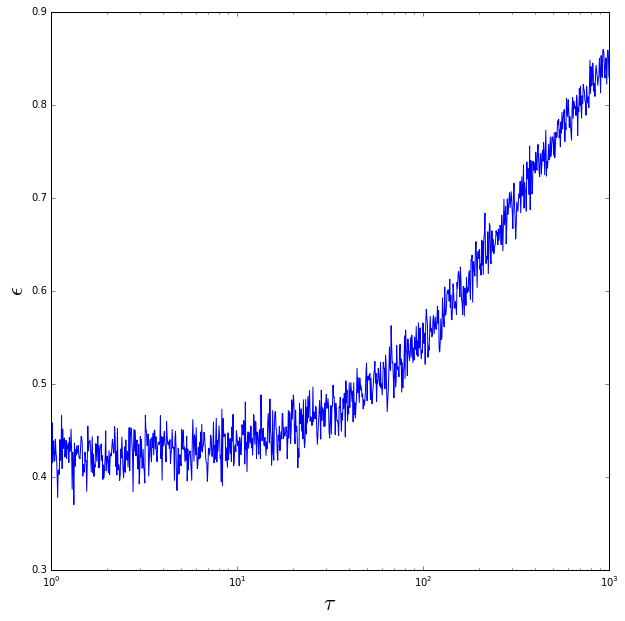

In [46]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(tau,delta)
ax.set_xscale('log')
ax.set_xlabel(r'$\tau$',fontsize=22)
ax.set_ylabel(r'$\epsilon$',fontsize=22)
plt.show()

##Estimating Mean of Power-law Distribution

Using our expressions for $H_n$ and the definition of $\langle x\rangle$, the event-averaged heating rate, we can come up with expression $$H_n=\frac{\tau/2\langle x\rangle}{\tau+T_n},$$ where we can see that as $T_n$ increases, $H_n$ will decrease unless $\tau$ or $\langle x\rangle$ is adjusted appropriately. Let's assume fixed $\tau$,$H_n$ and see how $\langle x\rangle$ changes with $T_n$ and then compare this to some actual heating rate averages.

In [47]:
def mean_heating_rate(tau,L,tpeak,t_wait):
    hn = heating_rate_approx(tpeak,L)
    return hn*(tau + t_wait)/(tau/2.0)

In [59]:
#typical parameters
tau = 200.0
L = np.arange(20.0,140.0,20.0)
t_wait = np.arange(250,5250,250)
tpeak = 4.0e+6

In [60]:
xbrack = []
for l in L:
    xbrack_temp = []
    for t in t_wait:
        xbrack_temp.append(mean_heating_rate(tau,l*10**8,tpeak,t))
    xbrack.append(xbrack_temp)

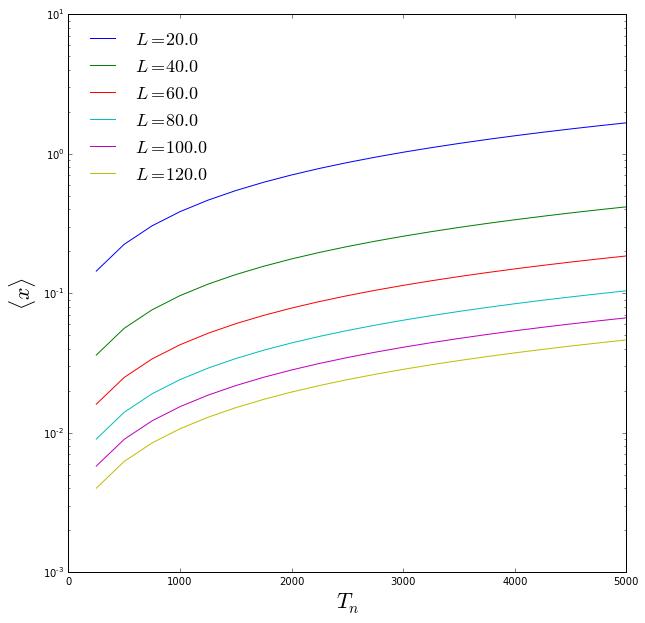

In [62]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in range(len(L)):
    ax.plot(t_wait,xbrack[i],label=r'$L=%.1f$'%L[i])
ax.set_xlabel(r'$T_n$',fontsize=22)
ax.set_ylabel(r'$\langle x\rangle$',fontsize=22)
ax.set_yscale('log')
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()

How do these values compare to some typical values for our distributions? 

In [65]:
num_samples = 1e+5
#first choose the range 10^23-10^25
q0 = 1.0e+23
q1 = 1.0e+25
#construct list of mean h values
xbrack = []
for a in alphas:
    xbrack_temp = []
    for l in L:
        a0 = en2vol_en_rate(q0,l*10**8,A,tau)
        a1 = en2vol_en_rate(q1,l*10**8,A,tau)
        xbrack_temp.append(np.mean(pl_dist(a0,a1,a,np.random.rand(num_samples))))
    xbrack.append(xbrack_temp)

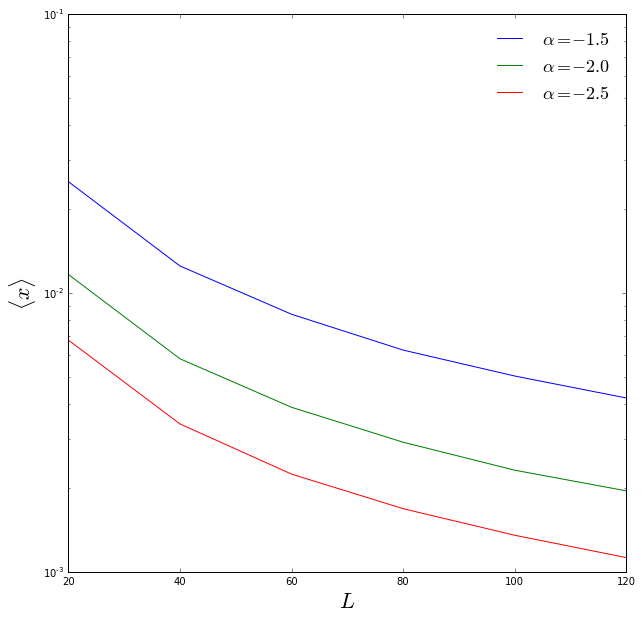

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in range(len(alphas)):
    ax.plot(L,xbrack[i],label=r'$\alpha=%.1f$'%alphas[i])
ax.set_xlabel(r'$L$',fontsize=22)
ax.set_ylabel(r'$\langle x\rangle$',fontsize=22)
ax.set_yscale('log')
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()

In [68]:
#Change range
q0 = 1.0e+24
q1 = 1.0e+25
#construct list of mean h values
xbrack = []
for a in alphas:
    xbrack_temp = []
    for l in L:
        a0 = en2vol_en_rate(q0,l*10**8,A,tau)
        a1 = en2vol_en_rate(q1,l*10**8,A,tau)
        xbrack_temp.append(np.mean(pl_dist(a0,a1,a,np.random.rand(num_samples))))
    xbrack.append(xbrack_temp)

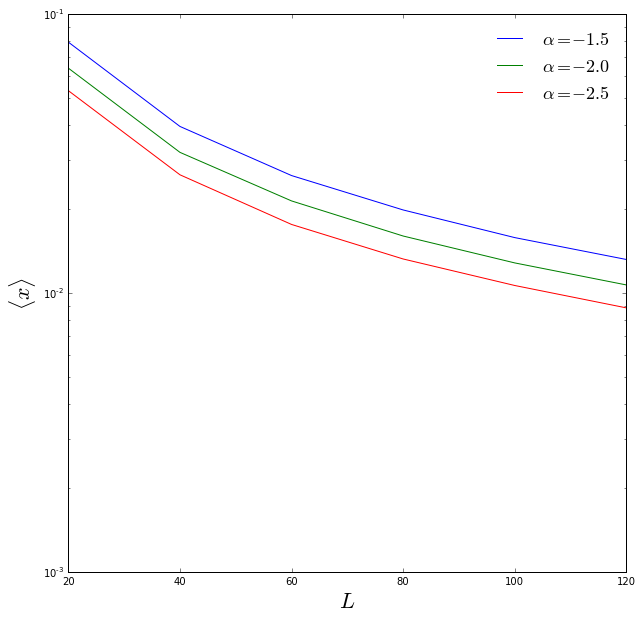

In [69]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in range(len(alphas)):
    ax.plot(L,xbrack[i],label=r'$\alpha=%.1f$'%alphas[i])
ax.set_xlabel(r'$L$',fontsize=22)
ax.set_ylabel(r'$\langle x\rangle$',fontsize=22)
ax.set_yscale('log')
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()

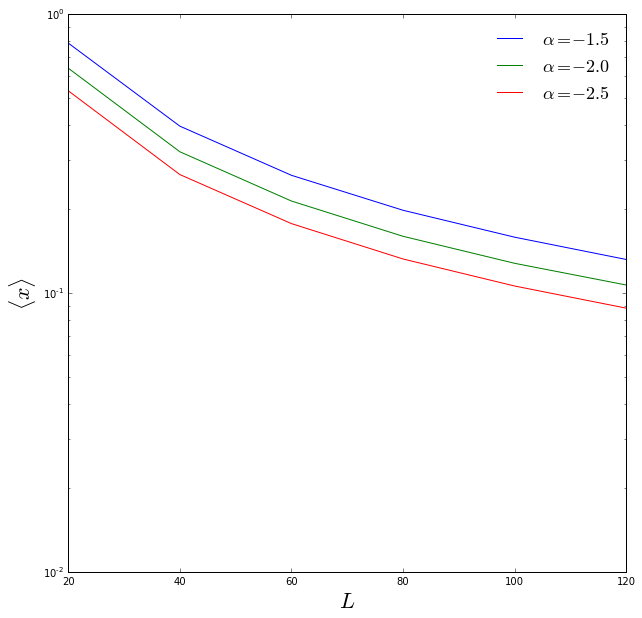

In [70]:
#Change range
q0 = 1.0e+25
q1 = 1.0e+26
#construct list of mean h values
xbrack = []
for a in alphas:
    xbrack_temp = []
    for l in L:
        a0 = en2vol_en_rate(q0,l*10**8,A,tau)
        a1 = en2vol_en_rate(q1,l*10**8,A,tau)
        xbrack_temp.append(np.mean(pl_dist(a0,a1,a,np.random.rand(num_samples))))
    xbrack.append(xbrack_temp)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in range(len(alphas)):
    ax.plot(L,xbrack[i],label=r'$\alpha=%.1f$'%alphas[i])
ax.set_xlabel(r'$L$',fontsize=22)
ax.set_ylabel(r'$\langle x\rangle$',fontsize=22)
ax.set_yscale('log')
lg = ax.legend(loc='best',fontsize=18)
lg.draw_frame(False)
plt.show()